Bibliotheken

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from model_ARIMA import build_ARIMA_model, grid_search
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test
from test_variance import goldfeldquandt_test, breuschpagan_test, koenkerbasset_test
from test_normal import hist_plot, kolmogorov_test
from time_series import seasonal_plot, seasonal_subseries_plot, decompose


warnings.filterwarnings("ignore")

Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)

store_number = 1
# Filtern nach Store
store = df[df['Store'] == store_number].copy()

# Datensatz nach Datum sortieren und als Index setzen
store.sort_values('Date', inplace=True)
store.set_index('Date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store['Weekly_Sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

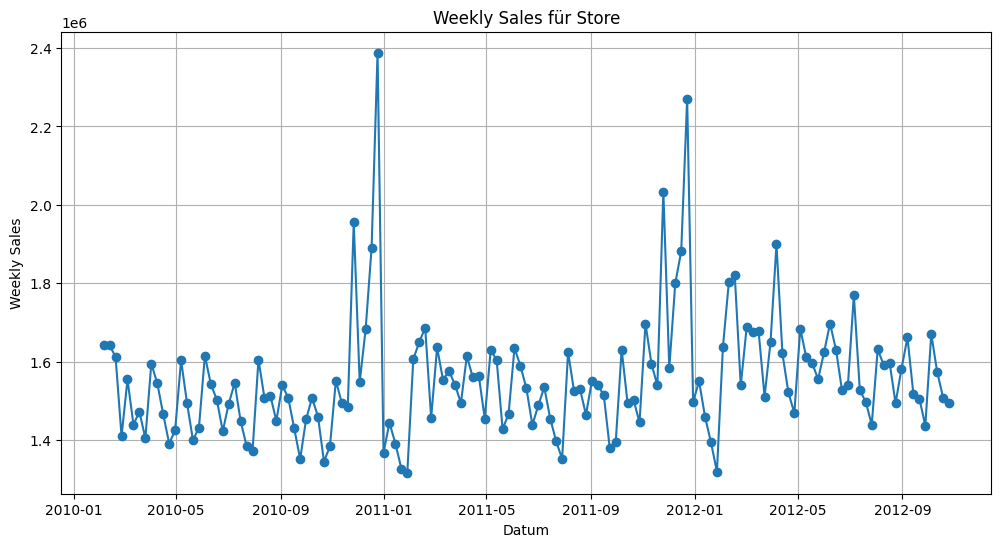

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

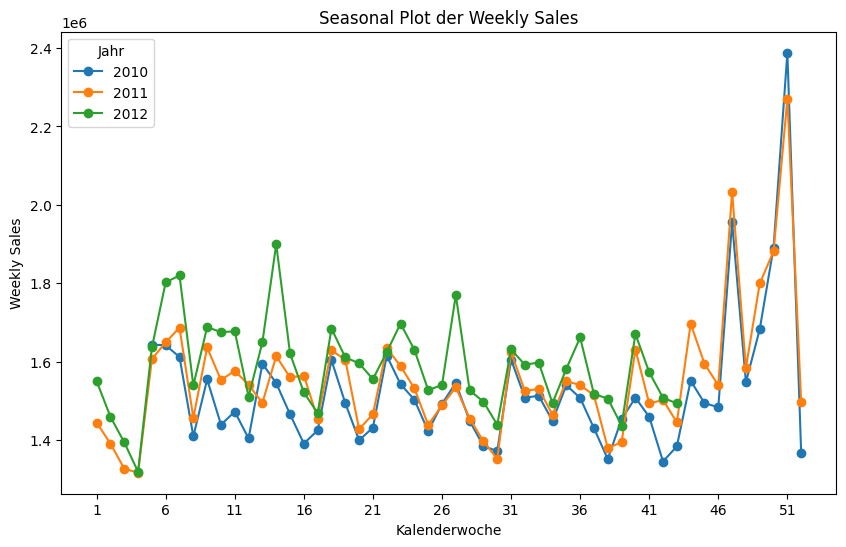

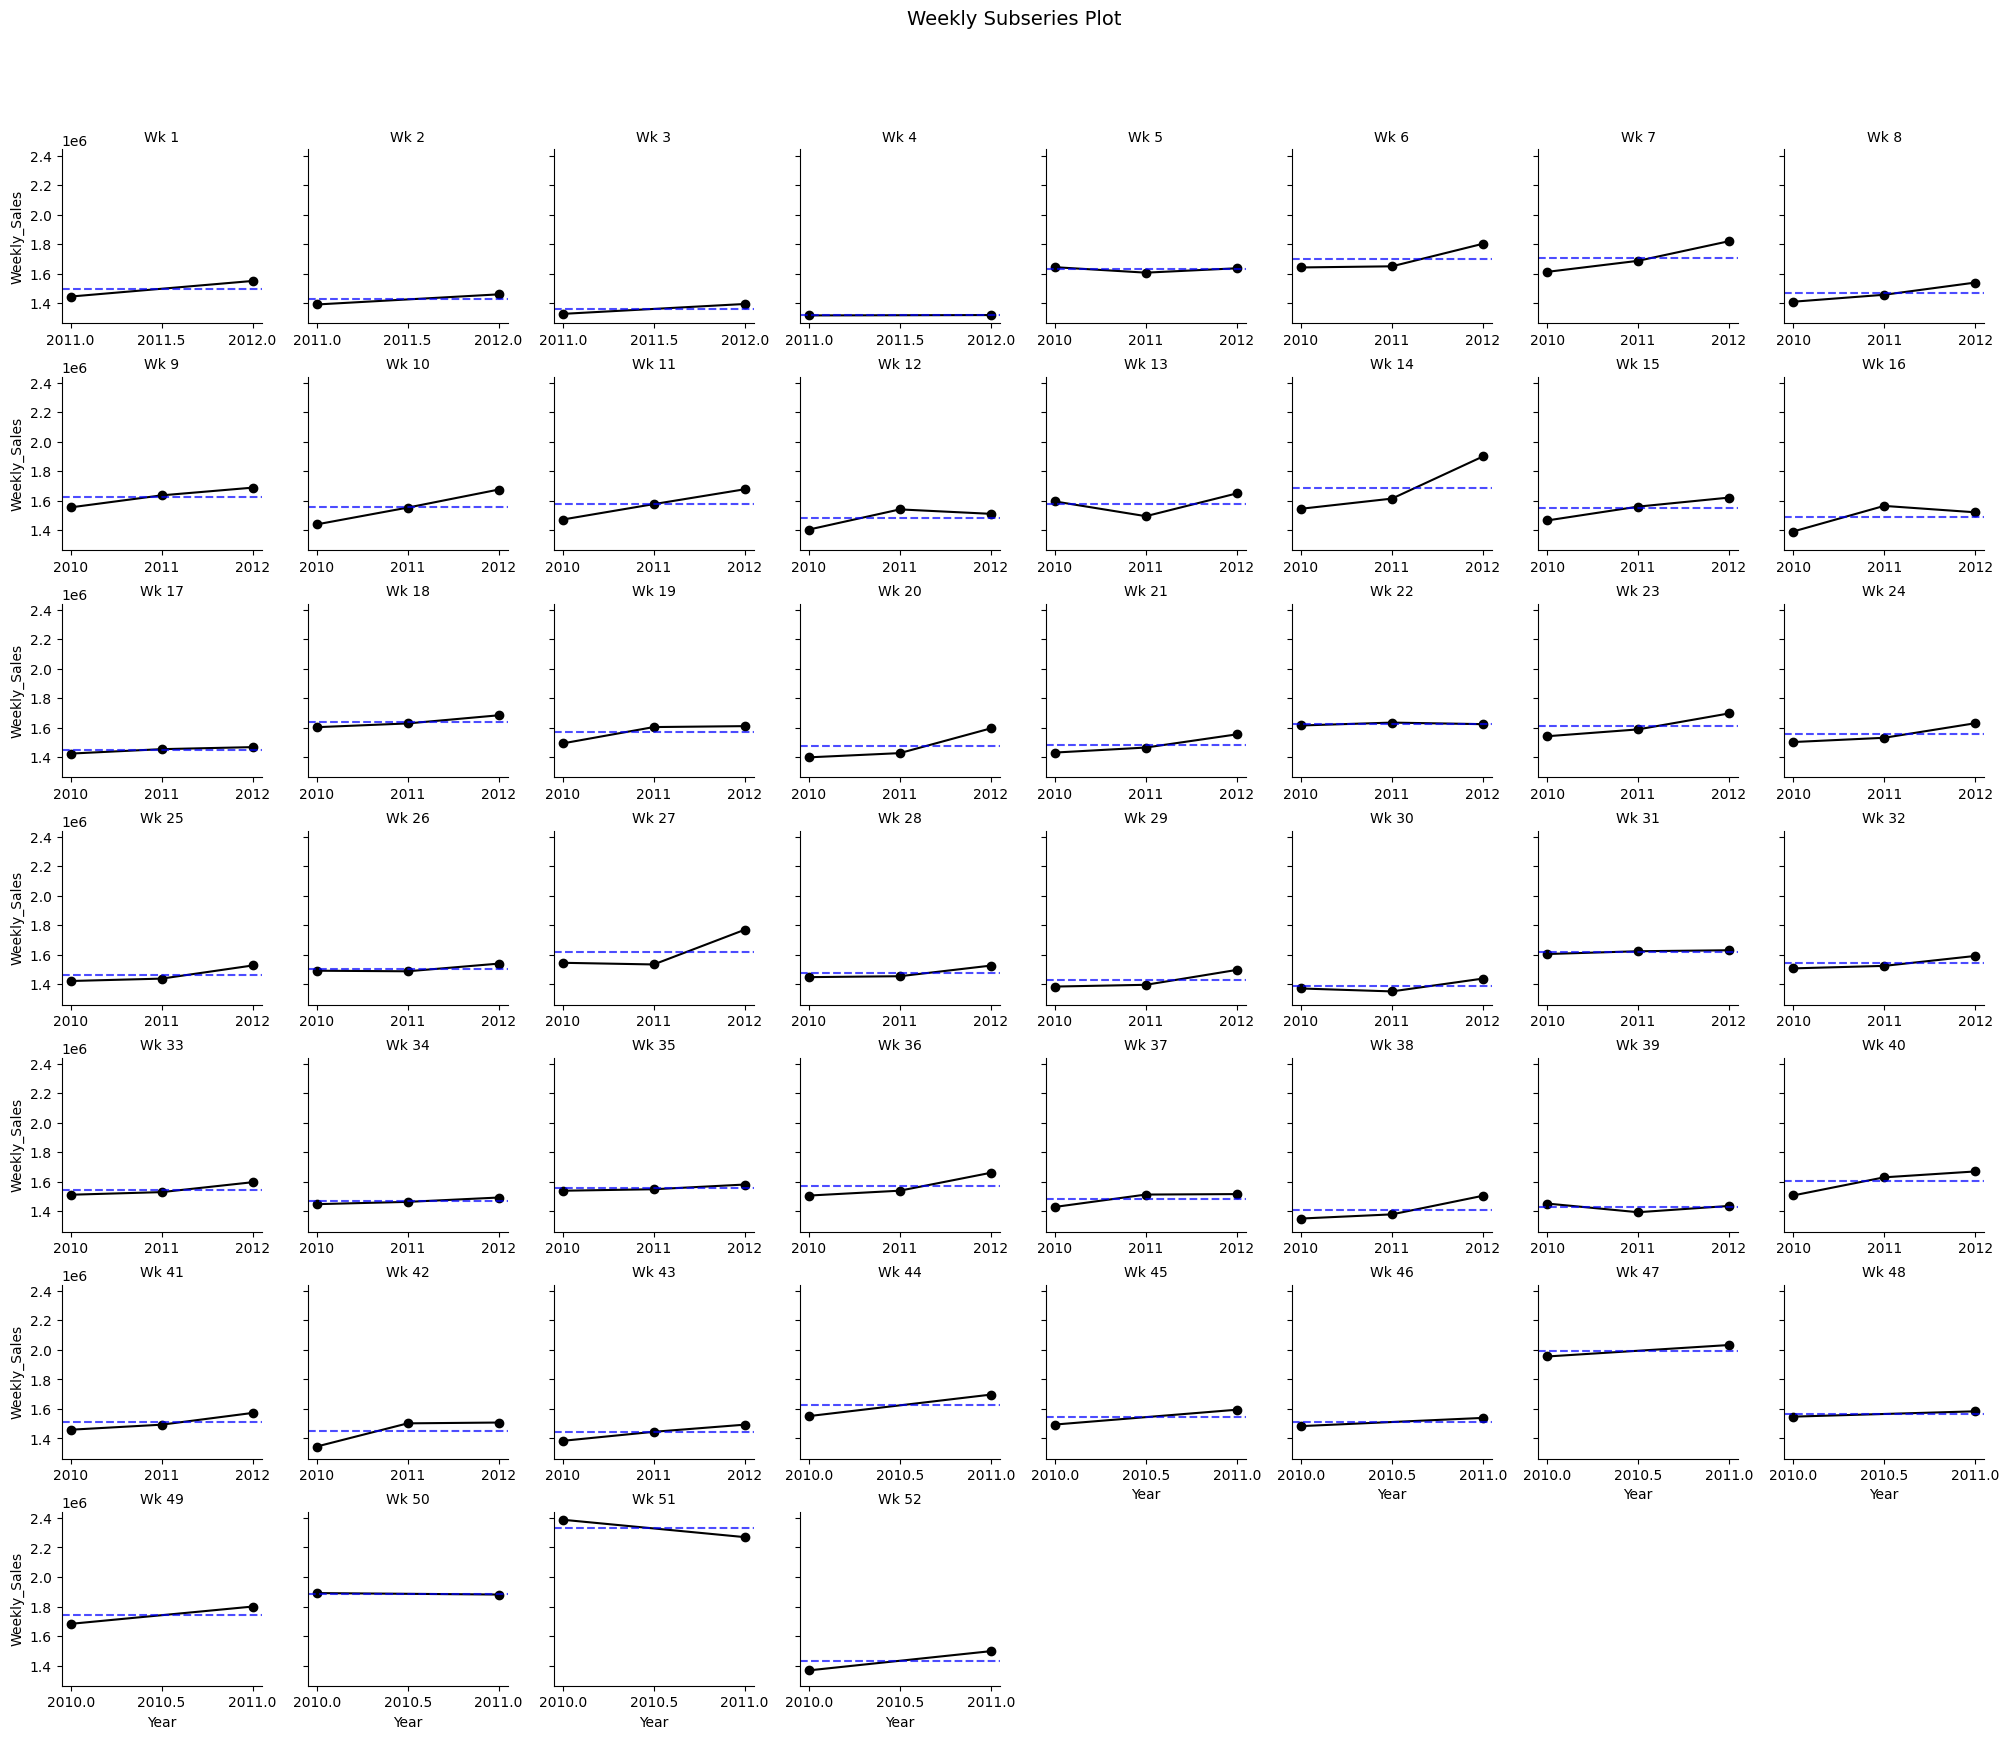

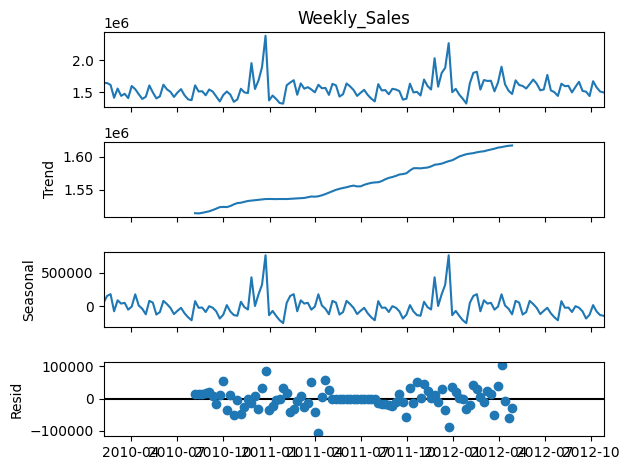

In [4]:
seasonal_plot(sales)
seasonal_subseries_plot(sales)
decompose(sales)




ARIMA Modell

In [5]:
arima_resid, arima_fitted = build_ARIMA_model(sales, grid_search(sales))


Bestes Modell: ARIMA(2, 0, 2) mit AIC: 3802.21


Naives Modell

In [6]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Aussuchen

Mittelwert der Residuen: 38104.2508


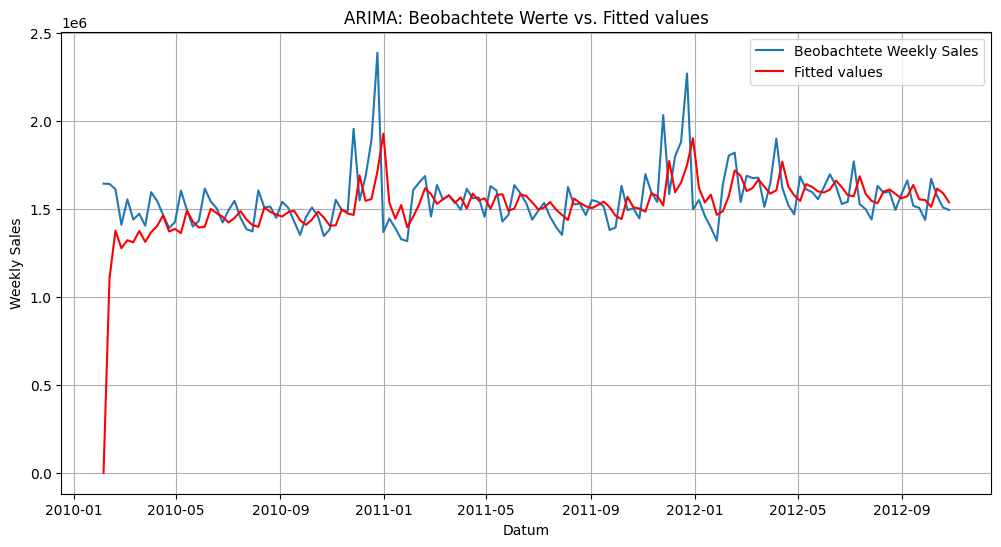

In [7]:
#residuen = naiv_resid
#fitted_values = naiv_fitted
residuen = arima_resid
fitted_values = arima_fitted


mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachtete Weekly Sales')
plt.plot(fitted_values, color='red', label='Fitted values')
plt.title('ARIMA: Beobachtete Werte vs. Fitted values')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

Tests

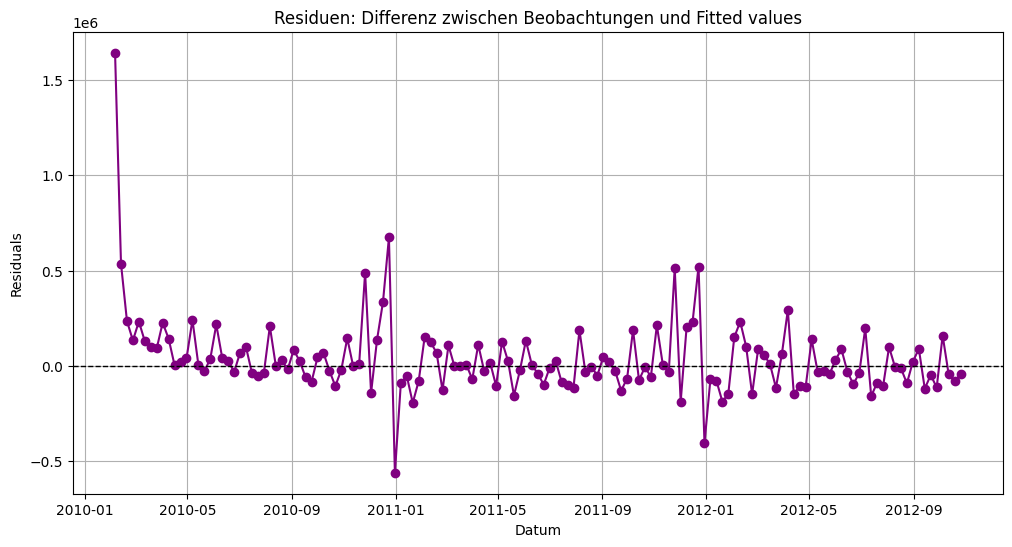

<Figure size 1200x600 with 0 Axes>

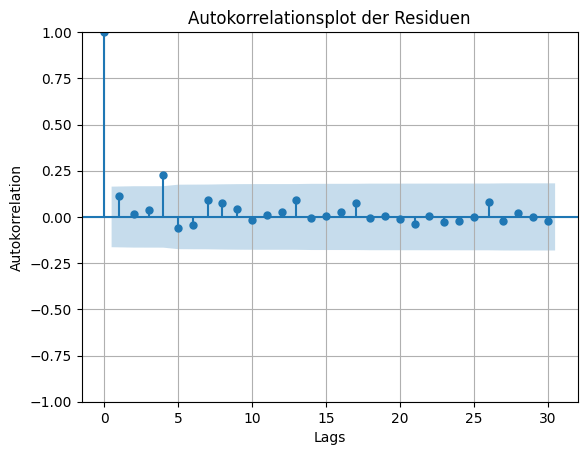

In [8]:
residual_plot(residuen)
acf_plot(residuen)